# Solving Full Cell Simulation Using the Discontinuous Galerkin Method with Interior Penalty
Author: E Leshinka Molel

In this notebook we set to solve the full cell simulation equations for a solid-state battery. The full-cell is simplified to include three domains
- negative electrode
- solid electrolyte (SE) separator
- positive electrode

At the interface between negative electrode and SE, and the interface between SE and positive electrode, we have charge transfer reactions. For simplicity, linear kinetics are assumed.

Phase 1 is the solid active material and phase 2 is the SE.

Current flowing due to charge transfer reaction is given by linear kinetics expression:
$$i = \frac{F i_{o}}{RT}(\phi_1 - \phi_2 - U)$$

The above expression can be written twice, once for -ve electrode and once for +ve electrode.

In our case, for simplicity, infinite kinetics are assumed at the negative electrode and SE separator.

In [1]:
import os

import gmsh
import meshio
import numpy as np
import pyvista
import ufl
import warnings

from dolfinx import cpp, fem, io, mesh, nls, plot
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 div, dx, ds, dS, grad, inner, grad, avg, jump)

import commons, geometry, utils

warnings.simplefilter('ignore')

In [2]:
markers = {
    'ne_pcc': 0,
    'ne_se': 1,
    'pe_se': 2,
    'pe_pcc': 3,
    'ne': 4,
    'se': 5,
    'pe': 6,
    "insulated": 7,
}

points = [
    (5, 0, 0),
    (10, 0, 0),
    (20, 0, 0),
    (20, 5, 0),
    (10, 5, 0),
    (5, 5, 0),
]
gpoints = []
lines = []
workdir = "output/full-cell"
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(workdir, 'mesh.msh')
tria_meshfile = os.path.join(workdir, "tria.xdmf")
line_meshfile = os.path.join(workdir, "line.xdmf")
potential_resultsfile = os.path.join(workdir, "potential.xdmf")
gmsh.initialize()
gmsh.model.add('full-cell')
# gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 1)
# gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1)

for p in points:
    gpoints.append(
        gmsh.model.occ.addPoint(*p)
    )
for idx in range(0, len(points)-1):
    lines.append(
        gmsh.model.occ.addLine(gpoints[idx], gpoints[idx+1])
    )
lines.append(
    gmsh.model.occ.addLine(gpoints[-1], gpoints[0])
)
lines.append(
    gmsh.model.occ.addLine(gpoints[4], gpoints[1])
)

gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(1, [lines[5]], markers['ne_se'])
# gmsh.model.addPhysicalGroup(1, [lines[6]], markers['pe_se'])
gmsh.model.addPhysicalGroup(1, [lines[2]], markers['pe_pcc'])
gmsh.model.addPhysicalGroup(1, [lines[idx] for idx in [0, 1, 3, 4]], markers['insulated'])
gmsh.model.occ.synchronize()
se_loop = gmsh.model.occ.addCurveLoop([lines[idx] for idx in [0, 6, 4, 5]])
pe_loop = gmsh.model.occ.addCurveLoop([lines[idx] for idx in [1, 2, 3, 6]])
gmsh.model.occ.synchronize()
se_phase = gmsh.model.occ.addPlaneSurface([se_loop])
pe_phase = gmsh.model.occ.addPlaneSurface([pe_loop])
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(2, [se_phase], markers['se'])
gmsh.model.addPhysicalGroup(2, [pe_phase], markers['pe'])
gmsh.model.occ.synchronize()

# adaptive refinement
# gmsh.model.mesh.field.add("Distance", 1)
# gmsh.model.mesh.field.setNumbers(1, "EdgesList", lines)

# gmsh.model.mesh.field.add("Threshold", 2)
# gmsh.model.mesh.field.setNumber(2, "IField", 1)
# gmsh.model.mesh.field.setNumber(2, "LcMin", 0.1)
# gmsh.model.mesh.field.setNumber(2, "LcMax", 1)
# gmsh.model.mesh.field.setNumber(2, "DistMin", 0)
# gmsh.model.mesh.field.setNumber(2, "DistMax", 0.5)

# gmsh.model.mesh.field.add("Max", 5)
# gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
# gmsh.model.mesh.field.setAsBackgroundMesh(5)

gmsh.model.mesh.generate(2)
gmsh.write(output_meshfile)
gmsh.finalize()

mesh_2d = meshio.read(output_meshfile)
tria_mesh = geometry.create_mesh(mesh_2d, "triangle")
meshio.write(tria_meshfile, tria_mesh)
line_mesh = geometry.create_mesh(mesh_2d, "line")
meshio.write(line_meshfile, line_mesh)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.000356724s, CPU 0.000684s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00393637s, CPU 0.004289s)
Info    : 72 nodes 152 elements
Info    : Writing 'output/full-cell/mesh.msh'...
Info    : Done writing 'output/full-cell/mesh.msh'



In [3]:
comm = MPI.COMM_WORLD
with io.XDMFFile(comm, tria_meshfile, "r") as infile3:
    domain = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
    ct = infile3.read_meshtags(domain, name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim - 1)
with io.XDMFFile(comm, line_meshfile, "r") as infile2:
    ft = infile2.read_meshtags(domain, name="Grid")
meshtags = mesh.meshtags(domain, domain.topology.dim - 1, ft.indices, ft.values)
domaintags = mesh.meshtags(domain, domain.topology.dim, ct.indices, ct.values)

In [4]:
ds = ufl.Measure("ds", domain=domain, subdomain_data=meshtags)
dS = ufl.Measure("dS", domain=domain, subdomain_data=meshtags)

In [5]:
V = fem.FunctionSpace(domain, ("DG", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
n = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)

alpha = 10
gamma = 10

h = 2 * ufl.Circumradius(domain)
h_avg = avg(h)

In [6]:
# uD = fem.Function(V)
# a = 0.8
# c = 1
# uD.interpolate(lambda x: 1 + a * x[0]**2 + c * x[1]**2)
# uD.x.scatter_forward()
x = SpatialCoordinate(domain)

f = fem.Constant(domain, PETSc.ScalarType(0))
g = fem.Constant(domain, PETSc.ScalarType(0))

u_left = fem.Function(V)
with u_left.vector.localForm() as u0_loc:
    u0_loc.set(0)
u_right = fem.Function(V)
with u_right.vector.localForm() as u1_loc:
    u1_loc.set(0.01)
# u_insulated = fem.Function(V)
# with u_insulated.vector.localForm() as u2_loc:
#     u2_loc.set(-np.inf)

In [7]:
a = inner(grad(u), grad(v)) * dx - inner(n, grad(u)) * v * ds

# Add DG/IP terms
a += - inner(avg(grad(v)), jump(u, n)) * dS - inner(jump(v, n), avg(grad(u))) * dS
a += + (gamma / h_avg) * inner(jump(v, n), jump(u, n)) * dS

# Add Nitsche terms
a += - inner(n, grad(v)) * u * ds(markers['ne_se']) + alpha / h * inner(u, v) * ds(markers['ne_se'])
a += - inner(n, grad(v)) * u * ds(markers['pe_pcc']) + alpha / h * inner(u, v) * ds(markers['pe_pcc'])
L = inner(f, v) * dx 
L += - inner(n, grad(v)) * u_left * ds(markers['ne_se']) + alpha / h * inner(u_left, v) * ds(markers['ne_se'])
L += - inner(n, grad(v)) * u_right * ds(markers['pe_pcc']) + alpha / h * inner(u_right, v) * ds(markers['pe_pcc'])

# Nitsche terms for Neumann BC on insulated boundary
L += - (h / alpha) * inner(n, grad(v)) * g * ds(markers['insulated'])
L += + inner(g, v) * ds(markers['insulated'])

In [8]:
problem = fem.petsc.LinearProblem(a, L)
uh = problem.solve()
uh.name = 'potential'

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_bc71437aff37e2977afb5d446aa8802c112ad0fe' extension
INFO:root:/home/molel/.conda/envs/fenicsx-env/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/molel/.conda/envs/fenicsx-env/include -fPIC -O2 -isystem /home/molel/.conda/envs/fenicsx-env/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/molel/.conda/envs/fenicsx-env/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/molel/.conda/envs/fenicsx-env/include -fPIC -I/home/molel/.conda/envs/fenicsx-env/lib/python3.10/site-packages/ffcx/codegeneration -I/home/molel/.conda/envs/fenicsx-env/include/python3.10 -c libffcx_forms_bc71437aff37e2977afb5d446aa8802c112ad0fe.c -o ./libffcx_forms_bc71437aff37e2977afb5d446aa8802c112ad0fe.o -O2 -g0
INFO:root:/home/molel/.conda/envs/fenicsx-env/bin/x86_64-conda-linux-gnu-cc -shared -Wl,

In [9]:
with io.XDMFFile(comm, potential_resultsfile, "w") as outfile:
    outfile.write_mesh(domain)
    outfile.write_function(uh)

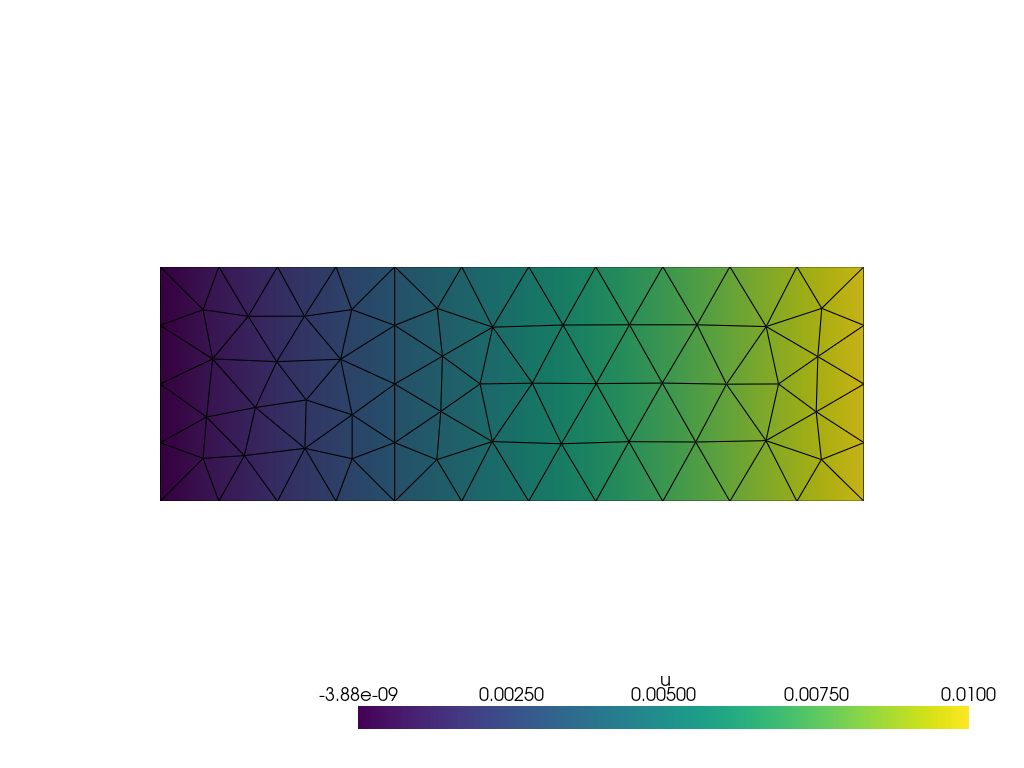

In [10]:
# pyvista.set_jupyter_backend('pythreejs')
pyvista.start_xvfb()
# We create a mesh consisting of the degrees of freedom for visualization
topology, cell_types, x = plot.create_vtk_mesh(V)
num_dofs_local = V.dofmap.index_map.size_local
grid = pyvista.UnstructuredGrid(topology, cell_types, V.tabulate_dof_coordinates()[:num_dofs_local])
# To make this function work in parallel, we only consider dofs owned by the current process
grid.point_data["u"] = uh.vector.array.real
grid.set_active_scalars("u")
warped = grid.warp_by_scalar("u", factor=1)

# Create plotter
plotter = pyvista.Plotter()
pyvista.start_xvfb(wait=0.05)
plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("DG.png")